In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import random
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam

In [2]:
# Set fixed seeding values for reproducability during experiments
# Skip this cell if random initialization (with varied results) is needed
np.random.seed(1234)
tf.random.set_seed(5678)

In [3]:
# Define the LeNet model
def create_lenet_model(input_shape, num_classes):
    model = Sequential()

    # First Convolutional Layer
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=2))
    model.add(Dropout(0.25))

    # Second Convolutional Layer
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=2))
    model.add(Dropout(0.25))

    # Third Convolutional Layer
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=2))
    model.add(Dropout(0.25))

    # Flatten Layer
    model.add(Flatten())

    # First Fully Connected (Dense) Layer
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Second Fully Connected (Dense) Layer
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Define batch_size
batch_size = 32

In [4]:
# Step 1: Clone the repository
!git clone https://github.com/y-lims/DADS7203_ThaiAlphabet_Homework.git

# Step 2: Access and process the files
import os
from PIL import Image
import numpy as np
import tensorflow as tf

# Define the paths to the image folders
image_folders = [
    '/content/DADS7203_ThaiAlphabet_Homework/ค',
    '/content/DADS7203_ThaiAlphabet_Homework/ฅ',
    '/content/DADS7203_ThaiAlphabet_Homework/ด',
    '/content/DADS7203_ThaiAlphabet_Homework/ต',
    '/content/DADS7203_ThaiAlphabet_Homework/ศ'
]
collected_labels = ['korkwai', 'korkon', 'dordek', 'tortao', 'sorsala']

fatal: destination path 'DADS7203_ThaiAlphabet_Homework' already exists and is not an empty directory.


In [5]:
# Initialize lists to hold all image data and labels
all_images = []
all_labels = []

# Define the image size
img_w, img_h = 112, 112

# Process each folder
for idx, folder in enumerate(image_folders):
    print(f"Processing folder: {folder}")

    # List all files in the folder
    images = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

    # Load each image in the folder
    for image_name in images:
        image_path = os.path.join(folder, image_name)

        # Use PIL to open and resize the image
        try:
            image = Image.open(image_path).convert('RGB')  # Convert to RGB if necessary
            image = image.resize((img_w, img_h))
            all_images.append(np.array(image))
            all_labels.append(collected_labels[idx])  # Use the actual label
        except Exception as e:
            print(f"Skipping image {image_name} due to error: {str(e)}")

# Convert lists to numpy arrays
all_images = np.array(all_images)

print(f"Collected {len(all_images)} images.")
print(f"Collected labels: {set(all_labels)}")

Processing folder: /content/DADS7203_ThaiAlphabet_Homework/ค
Processing folder: /content/DADS7203_ThaiAlphabet_Homework/ฅ
Processing folder: /content/DADS7203_ThaiAlphabet_Homework/ด
Processing folder: /content/DADS7203_ThaiAlphabet_Homework/ต
Processing folder: /content/DADS7203_ThaiAlphabet_Homework/ศ
Collected 1852 images.
Collected labels: {'korkwai', 'tortao', 'korkon', 'sorsala', 'dordek'}


In [6]:
# Resize all images to 32x32 and save to a new list
resized_images = []
for image in all_images:
    image_resized = Image.fromarray(image).resize((64, 64))
    resized_images.append(np.array(image_resized))

# Convert resized images list to numpy array
resized_images = np.array(resized_images)

# Create a DataFrame to store the resized images and their labels
df_resized = pd.DataFrame({
    'image': list(resized_images),  # Store the images as lists within the DataFrame
    'category': all_labels
})

# Display the first few rows of the DataFrame
print(df_resized.head())

                                               image category
0  [[[255, 255, 255], [255, 255, 255], [255, 255,...  korkwai
1  [[[255, 255, 255], [255, 255, 255], [255, 255,...  korkwai
2  [[[255, 255, 255], [255, 255, 255], [255, 255,...  korkwai
3  [[[255, 255, 255], [255, 255, 255], [255, 255,...  korkwai
4  [[[255, 255, 255], [255, 255, 255], [255, 255,...  korkwai


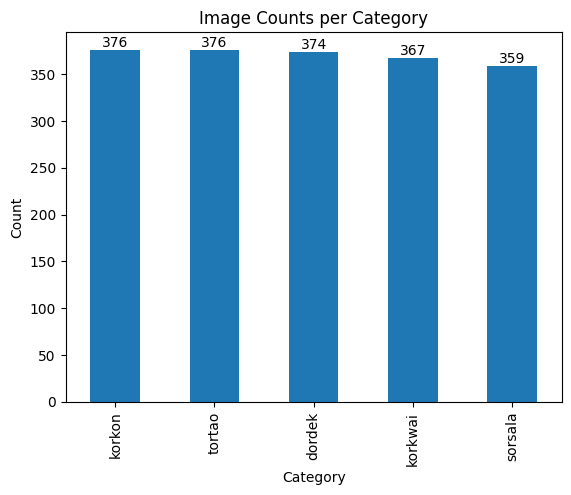

In [7]:
# Plot the bar chart with counts
category_counts = df_resized['category'].value_counts()
ax = category_counts.plot.bar()

# Annotate the bar chart with the counts
for i, count in enumerate(category_counts):
    ax.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Image Counts per Category')
plt.show()

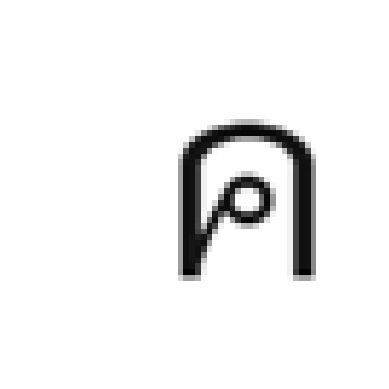

In [8]:
# Display a sample image
sample_index = random.choice(range(len(resized_images)))
sample_image = array_to_img(resized_images[sample_index])
plt.imshow(sample_image)
plt.axis('off')  # Hide the axes
plt.show()

In [9]:
# แปลงรูปภาพเป็นขาวดำ (1 channel)
resized_images_gray = np.array([cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in resized_images])
resized_images_gray = resized_images_gray[..., np.newaxis]  # เพิ่ม channel dimension

# Convert images to float32 and normalize
resized_images_gray = resized_images_gray.astype('float32') / 255.0

# Convert labels to categorical format
categories = {'korkwai': 0, 'korkon': 1, 'dordek': 2, 'tortao': 3, 'sorsala': 4}
df_resized['category'] = df_resized['category'].map(categories)
labels = to_categorical(df_resized['category'], num_classes=len(categories))


# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(resized_images_gray, labels, test_size=0.40, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

# Data Augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False
        )
datagen.fit(X_train)



# Define the LeNet model with the correct input shape
input_shape = (64, 64, 1)  # black-and-white images have 1 channel
num_classes = len(categories)
lenet_model = create_lenet_model(input_shape, num_classes)

# Compile the model
lenet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

# Fit the model and store the history
history = lenet_model.fit(X_train, y_train, epochs=150, batch_size=batch_size, validation_data=(X_val, y_val))

# Print summary to verify the model structure
lenet_model.summary()

Epoch 1/150
35/35 [==============================] - 25s 525ms/step - loss: 2.6672 - accuracy: 0.2421 - val_loss: 1.6247 - val_accuracy: 0.1973
Epoch 2/150
35/35 [==============================] - 15s 431ms/step - loss: 2.4249 - accuracy: 0.2457 - val_loss: 1.6468 - val_accuracy: 0.1973
Epoch 3/150
35/35 [==============================] - 14s 414ms/step - loss: 2.3277 - accuracy: 0.2871 - val_loss: 1.6719 - val_accuracy: 0.2081
Epoch 4/150
35/35 [==============================] - 21s 613ms/step - loss: 2.2413 - accuracy: 0.3006 - val_loss: 1.7935 - val_accuracy: 0.2027
Epoch 5/150
35/35 [==============================] - 15s 443ms/step - loss: 2.2813 - accuracy: 0.3078 - val_loss: 1.9048 - val_accuracy: 0.1865
Epoch 6/150
35/35 [==============================] - 15s 431ms/step - loss: 2.0721 - accuracy: 0.3411 - val_loss: 2.1791 - val_accuracy: 0.1757
Epoch 7/150
35/35 [==============================] - 15s 440ms/step - loss: 2.0562 - accuracy: 0.3393 - val_loss: 2.3972 - val_accuracy:

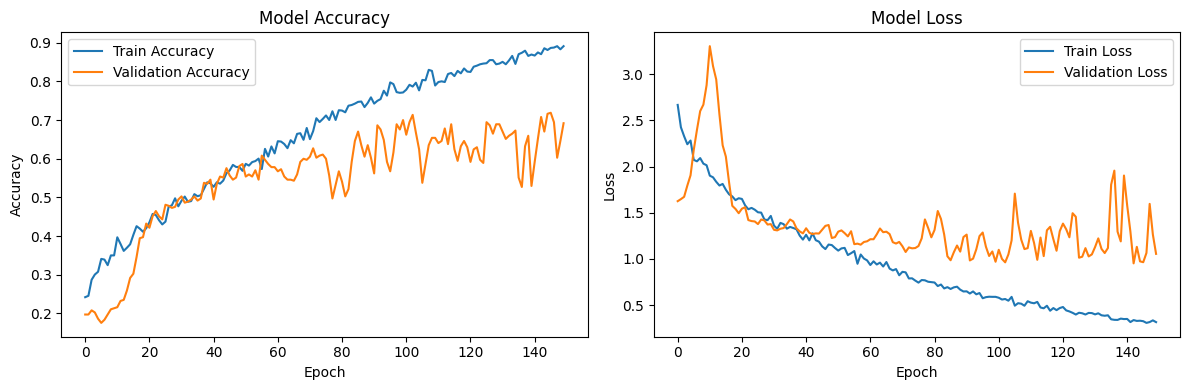

In [10]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
# Evaluate the model
test_loss, test_accuracy = lenet_model.evaluate(X_val, y_val)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')
print(f'Test loss: {test_loss:.4f}')

12/12 [==============================] - 2s 128ms/step - loss: 1.0540 - accuracy: 0.6919
Test accuracy: 69.19%
Test loss: 1.0540


samples.shape=(10, 64, 64, 1)
1/1 [==============================] - 0s 362ms/step


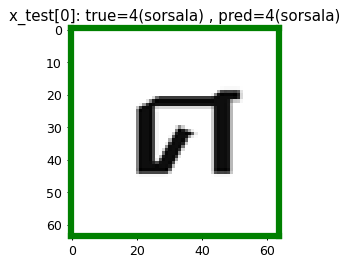

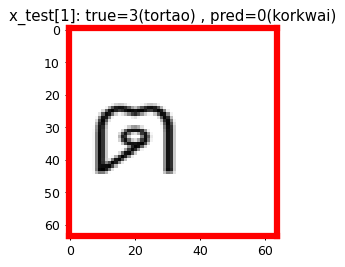

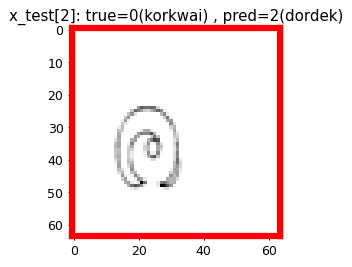

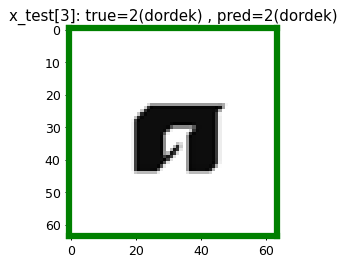

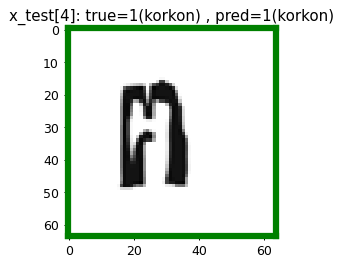

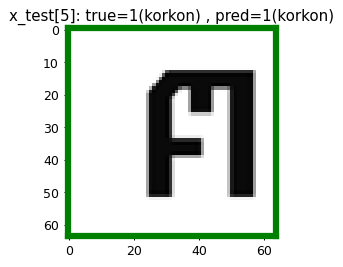

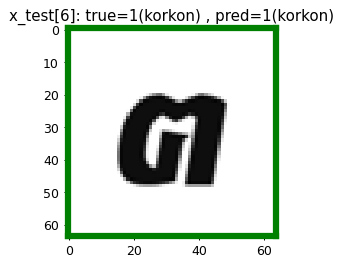

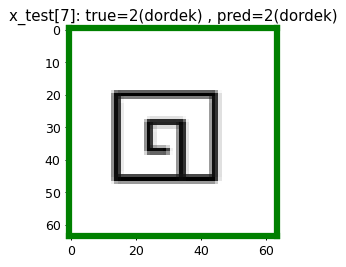

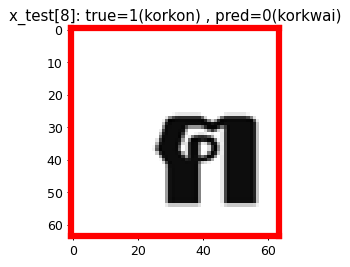

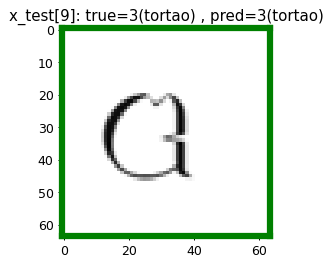

In [12]:
# Optional codes for coloring frames of the predicted images
plt.rcParams["axes.linewidth"] = 5

def color_frame(ax, y_true, y_pred):
    # Green frame means correct prediction. Red frame means incorrect prediction.
    color = 'green' if (y_true == y_pred) else 'red'
    ax.spines['bottom'].set_color(color)
    ax.spines['top'].set_color(color)
    ax.spines['right'].set_color(color)
    ax.spines['left'].set_color(color)

# Assuming x_test is in [0, 1] range, scale to [0, 255]
x_test_display = (X_test * 255).astype(np.uint8)

n = 10
samples = X_test[:n]
print(f'{samples.shape=}')

# Predict a batch of samples
y_pred = lenet_model.predict(samples)

for i in range(n):
    plt.figure(figsize=(3, 3), dpi=90)
    ax = plt.gca()
    # Display the grayscale image
    plt.imshow(x_test_display[i].squeeze(), cmap='gray')
    true_label = np.argmax(y_test[i])
    pred_label = np.argmax(y_pred[i])
    plt.title(f"x_test[{i}]: true={true_label}({collected_labels[true_label]}) , pred={pred_label}({collected_labels[pred_label]})")
    color_frame(ax, true_label, pred_label)
    plt.show()

# collected_labels = ['korkwai', 'korkon', 'dordek', 'tortao', 'sorsala']


3/3 [==============================] - 1s 369ms/step - loss: 0.6790 - accuracy: 0.7493
['loss', 'accuracy']: [0.6790116429328918, 0.7493261694908142]
12/12 [==============================] - 1s 78ms/step
Confusion Matrix:
[[61  7  5  0  1]
 [ 7 59  1  4  2]
 [11  3 69  2  0]
 [ 3 26  8 27  0]
 [ 5  7  0  1 62]]
Accuracy: 0.7493
Precision: 0.7739
Recall: 0.7493
F1 Score: 0.7461


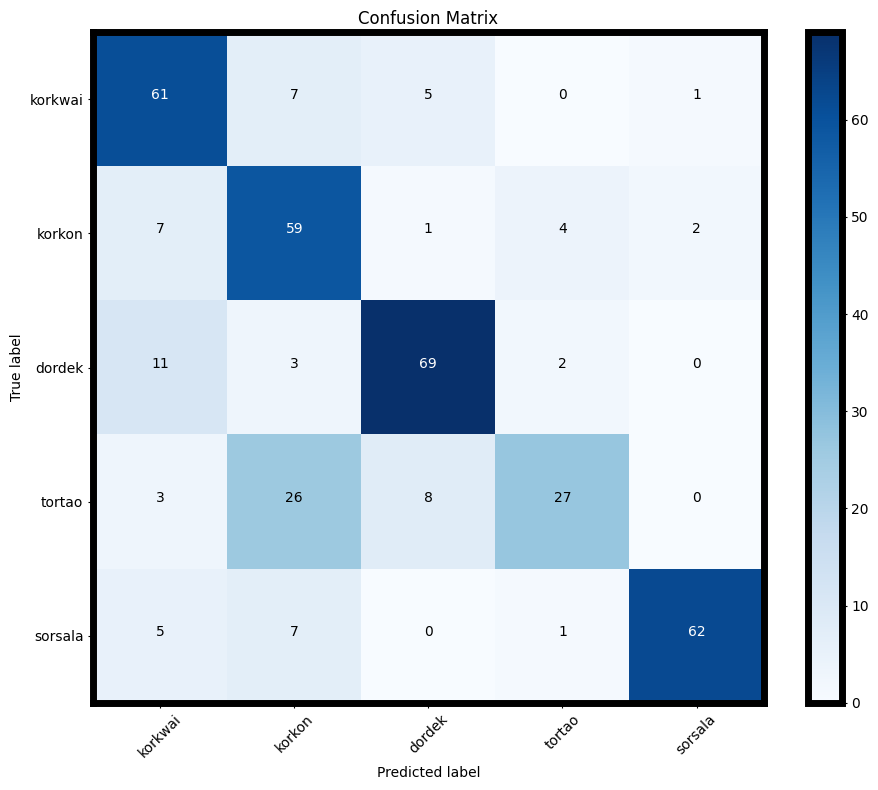

In [13]:
import itertools
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Evaluate the trained model on the test set
results = lenet_model.evaluate(X_test, y_test, batch_size=128)
print(f"{lenet_model.metrics_names}: {results}")

# Predict on the full test set
y_pred_full = lenet_model.predict(X_test)
predicted_labels = np.argmax(y_pred_full, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Print results
print("Confusion Matrix:")
print(cm)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(collected_labels))
plt.xticks(tick_marks, collected_labels, rotation=45)
plt.yticks(tick_marks, collected_labels)

# Add labels to the confusion matrix plot
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


In [14]:
for layer in lenet_model.layers:
    print(layer.name)

conv2d
batch_normalization
max_pooling2d
dropout
conv2d_1
batch_normalization_1
max_pooling2d_1
dropout_1
conv2d_2
batch_normalization_2
max_pooling2d_2
dropout_2
flatten
dense
batch_normalization_3
dropout_3
dense_1
batch_normalization_4
dropout_4
dense_2


In [15]:
def compute_gradcam(input_model, image, cls, layer_name):
    # สร้าง functional model ใหม่
    last_conv_layer = input_model.get_layer(layer_name)
    last_conv_layer_model = Model(inputs=input_model.inputs, outputs=last_conv_layer.output)

    # สร้าง model สำหรับ class prediction
    classifier_input = Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer in input_model.layers[input_model.layers.index(last_conv_layer)+1:]:
        x = layer(x)
    classifier_model = Model(inputs=classifier_input, outputs=x)

    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer
        last_conv_layer_output = last_conv_layer_model(image)
        tape.watch(last_conv_layer_output)
        # Predict the class
        preds = classifier_model(last_conv_layer_output)
        class_output = preds[:, cls]

    # Gradient of the class output with respect to the last conv layer output
    grads = tape.gradient(class_output, last_conv_layer_output)

    # Global average pooling
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map with its gradient importance
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()

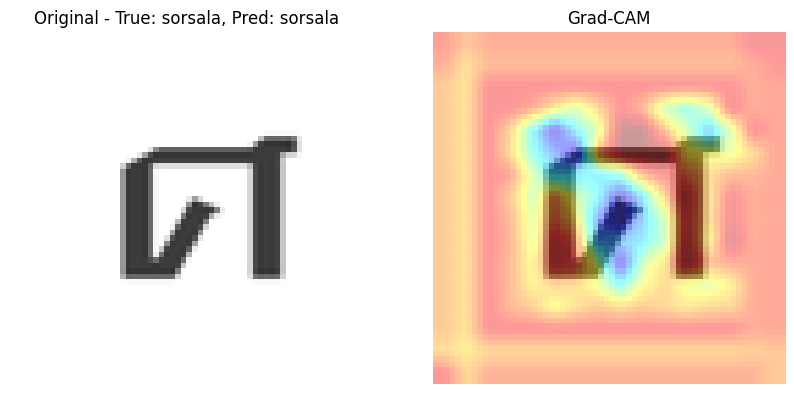

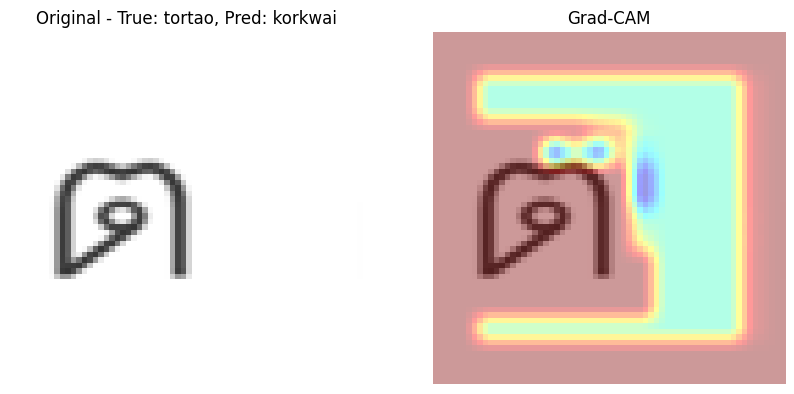

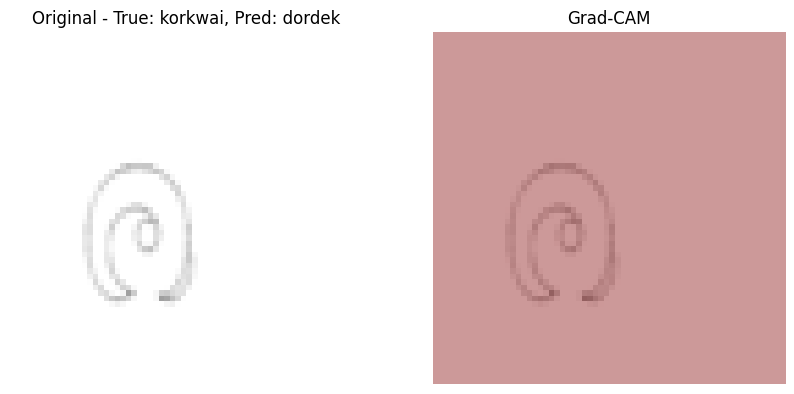

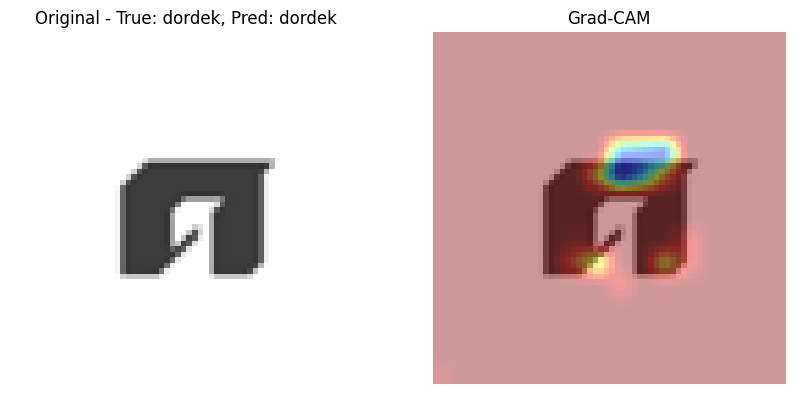

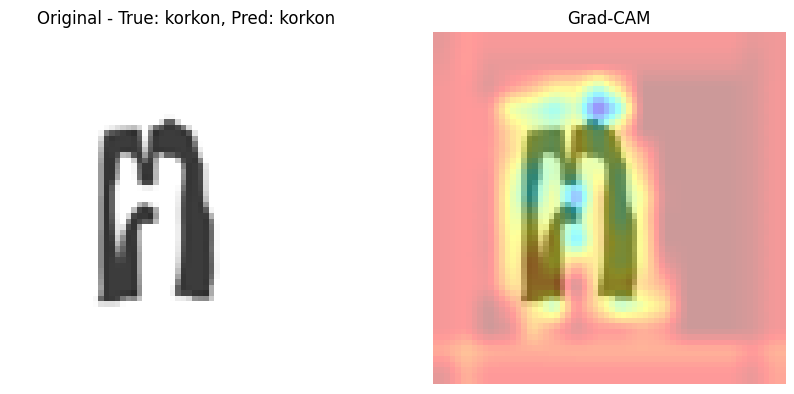

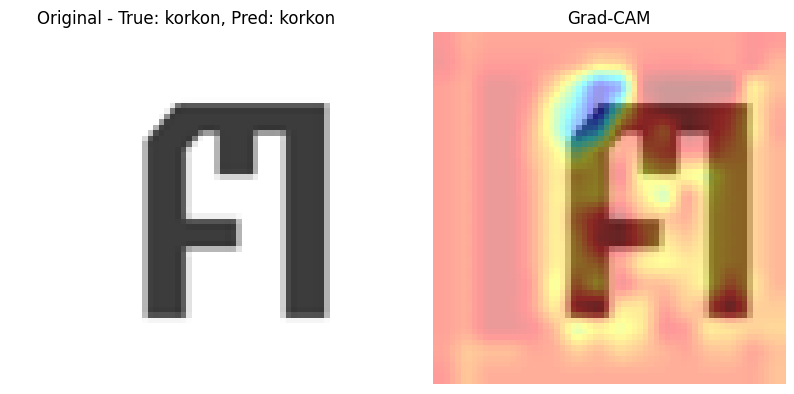

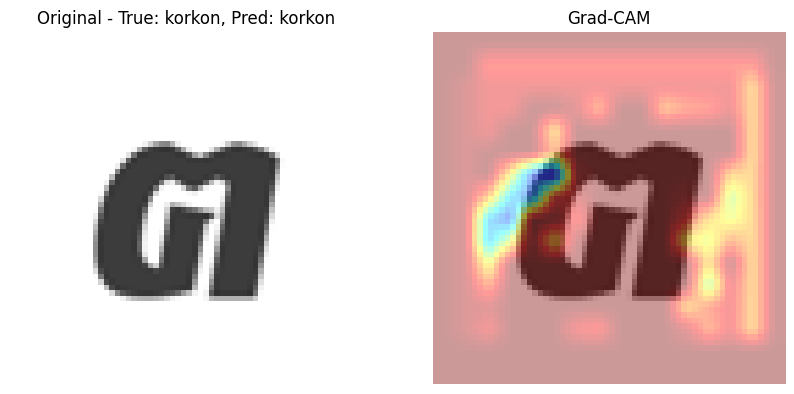

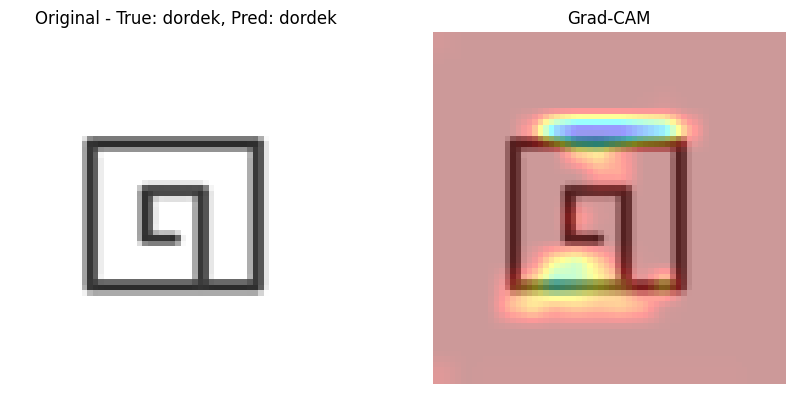

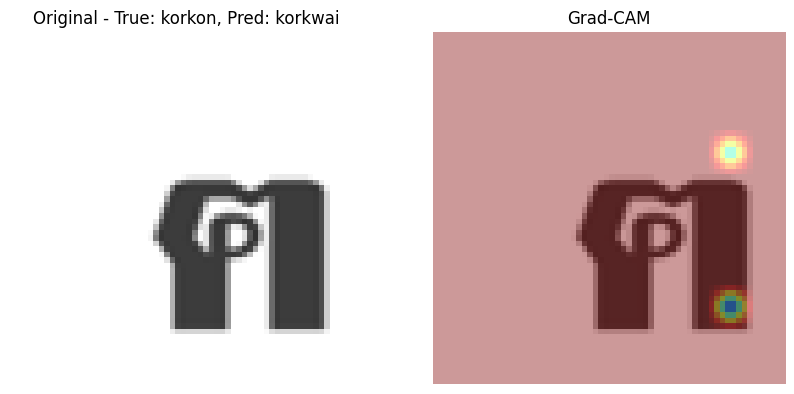

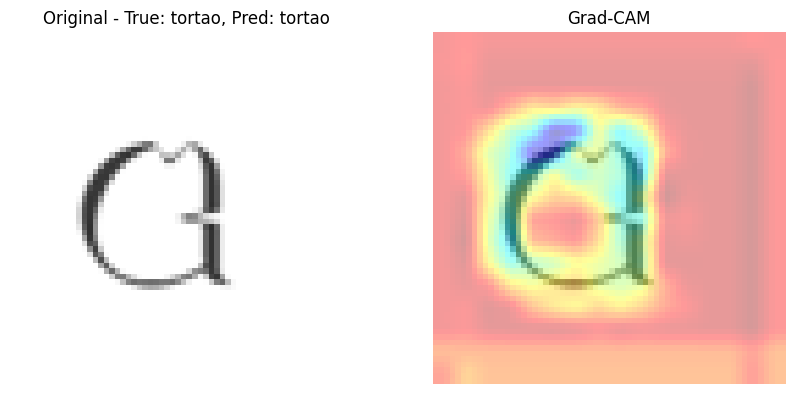

In [16]:
# Assuming n, samples, y_pred, x_test_display, y_test, collected_labels are defined

def compute_gradcam(input_model, image, cls, layer_name):
    # Create a new functional model
    last_conv_layer = input_model.get_layer(layer_name)
    last_conv_layer_model = Model(inputs=input_model.inputs, outputs=last_conv_layer.output)

    # Create model for class prediction
    classifier_input = Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer in input_model.layers[input_model.layers.index(last_conv_layer)+1:]:
        x = layer(x)
    classifier_model = Model(inputs=classifier_input, outputs=x)

    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer
        last_conv_layer_output = last_conv_layer_model(image)
        tape.watch(last_conv_layer_output)
        # Predict the class
        preds = classifier_model(last_conv_layer_output)
        class_output = preds[:, cls]

    # Gradient of the class output with respect to the last conv layer output
    grads = tape.gradient(class_output, last_conv_layer_output)

    # Global average pooling
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map with its gradient importance
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()

for i in range(n):
    image = np.expand_dims(samples[i], axis=0)
    predicted_class = np.argmax(y_pred[i])

    # Use the correct layer name (e.g., 'conv2d_3' or the name you found by printing the layer names)
    cam = compute_gradcam(lenet_model, image, predicted_class, "conv2d_2")

    heatmap = np.uint8(255 * cam)
    heatmap = cv2.resize(heatmap, (64, 64))  # Resize to match the input image size
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    img = x_test_display[i].squeeze()
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # Ensure the sizes match
    if heatmap.shape[:2] != img.shape[:2]:
        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title(f"Original - True: {collected_labels[np.argmax(y_test[i])]}, Pred: {collected_labels[predicted_class]}")
    plt.imshow(img, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM")
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()